# NUM_FRAMES Comparison: 8 vs 16

**2 Experiments on 2 GPUs:**
- GPU 0: NUM_FRAMES=8, Paper Baseline
- GPU 1: NUM_FRAMES=8, Full Custom (Consistent + Mixup + 2-Stage + Flip TTA)

In [17]:
!gdown "1Xv2CWOqdBj3kt0rkNJKRsodSIEd3-wX_" -O test_labels.csv -q

In [18]:
%%writefile worker_8frames_baseline.py
#!/usr/bin/env python3
"""GPU 0: NUM_FRAMES=8, Paper Baseline"""
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings('ignore')

import random, numpy as np, torch, torch.nn as nn, torch.nn.functional as F, time
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from PIL import Image
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from transformers import VideoMAEForVideoClassification, VideoMAEImageProcessor, get_cosine_schedule_with_warmup
import pandas as pd
from sklearn.metrics import accuracy_score

PATH_TRAIN = Path('/kaggle/input/action-video/data/data_train')
PATH_TEST = Path('/kaggle/input/action-video/data/test')
MODEL_CKPT = "MCG-NJU/videomae-base-finetuned-kinetics"
NUM_FRAMES, IMG_SIZE, RESIZE = 8, 224, 256
BATCH, ACCUM, EPOCHS, LR, WD = 40, 2, 10, 5e-5, 0.05
device = torch.device('cuda:0')
gpu_id = 0
proc = VideoMAEImageProcessor.from_pretrained(MODEL_CKPT)
MEAN, STD = proc.image_mean, proc.image_std

class DS(Dataset):
    def __init__(self, root):
        self.root = Path(root)
        self.classes = sorted([d.name for d in self.root.iterdir() if d.is_dir()])
        self.c2i = {c:i for i,c in enumerate(self.classes)}
        self.samples = [(v, self.c2i[c]) for c in self.classes for v in (self.root/c).iterdir() if v.is_dir()]
    def __len__(self): return len(self.samples)
    def __getitem__(self, i):
        v, l = self.samples[i]
        fs = sorted(v.glob('*.jpg'))
        idx = torch.linspace(0, len(fs)-1, NUM_FRAMES).long()
        fr = torch.stack([TF.to_tensor(Image.open(fs[j]).convert('RGB')) for j in idx])
        s = random.uniform(0.8,1.0)
        fr = TF.resize(fr, [int(fr.shape[-2]*s), int(fr.shape[-1]*s)])
        i,j = random.randint(0,max(0,fr.shape[-2]-IMG_SIZE)), random.randint(0,max(0,fr.shape[-1]-IMG_SIZE))
        fr = TF.resize(TF.crop(fr, i, j, min(IMG_SIZE,fr.shape[-2]), min(IMG_SIZE,fr.shape[-1])), [IMG_SIZE,IMG_SIZE])
        if random.random()<0.5: fr = TF.hflip(fr)
        return torch.stack([TF.normalize(f, MEAN, STD) for f in fr]), l

class TDS(Dataset):
    def __init__(self, root):
        self.root = Path(root)
        self.samples = sorted([(d,int(d.name)) for d in self.root.iterdir() if d.is_dir()], key=lambda x:x[1])
    def __len__(self): return len(self.samples)
    def __getitem__(self, i):
        v, vid = self.samples[i]
        fs = sorted(v.glob('*.jpg'))
        idx = torch.linspace(0, len(fs)-1, NUM_FRAMES).long()
        fr = [TF.resize(Image.open(fs[j]).convert('RGB'), RESIZE) for j in idx]
        return torch.stack([TF.normalize(TF.to_tensor(TF.center_crop(f, IMG_SIZE)), MEAN, STD) for f in fr]), vid

def train(m, ld, opt, sch, sc):
    m.train()
    loss_s, cor, tot = 0.0, 0, 0
    for bi, (x, y) in enumerate(ld):
        x, y = x.to(device), y.to(device)
        with torch.amp.autocast('cuda'):
            logits = m(x).logits
            loss = F.cross_entropy(logits, y)
        cor += (logits.argmax(1)==y).sum().item()
        tot += y.size(0)
        loss_s += loss.item() * y.size(0)
        sc.scale(loss/ACCUM).backward()
        if (bi+1) % ACCUM == 0:
            sc.unscale_(opt); torch.nn.utils.clip_grad_norm_(m.parameters(), 1.0)
            sc.step(opt); sc.update(); opt.zero_grad(); sch.step()
    return loss_s/tot, cor/tot

def evalu(m, ld):
    m.eval()
    ps = []
    with torch.no_grad():
        for x, ids in ld:
            ps.extend(zip(ids.tolist(), m(x.to(device)).logits.argmax(1).cpu().tolist()))
    return ps

print(f"[GPU{gpu_id}] Exp: 8frames_baseline")
random.seed(42); np.random.seed(42); torch.manual_seed(42)
tds = DS(PATH_TRAIN)
tes = TDS(PATH_TEST)
cn = tds.classes
m = VideoMAEForVideoClassification.from_pretrained(MODEL_CKPT, num_labels=len(cn), ignore_mismatched_sizes=True, num_frames=NUM_FRAMES).to(device)
tl = DataLoader(tds, BATCH, shuffle=True, num_workers=2, drop_last=True)
tel = DataLoader(tes, BATCH, num_workers=2)
opt = torch.optim.AdamW(m.parameters(), lr=LR, weight_decay=WD)
sc = torch.amp.GradScaler()
sch = get_cosine_schedule_with_warmup(opt, int(len(tl)*EPOCHS*0.1/ACCUM), len(tl)*EPOCHS//ACCUM)
gt = dict(zip(pd.read_csv('test_labels.csv')['id'].astype(str), pd.read_csv('test_labels.csv')['class']))

for ep in range(EPOCHS):
    ep_start = time.time()
    l, a = train(m, tl, opt, sch, sc)
    ps = evalu(m, tel)
    ta = accuracy_score([gt[str(i)] for i,_ in ps], [cn[p] for _,p in ps])
    ep_time = time.time() - ep_start; eta = ep_time * (EPOCHS - ep - 1)
    print(f"  [GPU{gpu_id}] Ep{ep+1}/{EPOCHS}: L={l:.4f}, Atr={a:.4f}, Ate={ta:.4f} | {ep_time//60:.0f}m{ep_time%60:.0f}s | ETA: {eta//60:.0f}m{eta%60:.0f}s", flush=True)

ps = evalu(m, tel)
fa = accuracy_score([gt[str(i)] for i,_ in ps], [cn[p] for _,p in ps])
print(f"  FINAL: {fa:.4f}")
pd.DataFrame([{'exp': '8frames_baseline', 'test_acc': fa, 'num_frames': 8, 'gpu': gpu_id}]).to_csv('results_8frames.csv', index=False)
print("Saved results_8frames.csv")

Overwriting worker_8frames_baseline.py


In [19]:
%%writefile worker_8frames_custom.py
#!/usr/bin/env python3
"""GPU 1: NUM_FRAMES=8, Full Custom Flow"""
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings('ignore')

import random, numpy as np, torch, torch.nn as nn, torch.nn.functional as F, time
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from PIL import Image
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from transformers import VideoMAEForVideoClassification, VideoMAEImageProcessor, get_cosine_schedule_with_warmup
import pandas as pd
from sklearn.metrics import accuracy_score

PATH_TRAIN = Path('/kaggle/input/action-video/data/data_train')
PATH_TEST = Path('/kaggle/input/action-video/data/test')
MODEL_CKPT = "MCG-NJU/videomae-base-finetuned-kinetics"
NUM_FRAMES, IMG_SIZE, RESIZE = 8, 224, 256
BATCH, ACCUM, EPOCHS, LR, WD = 40, 2, 10, 5e-5, 0.05
device = torch.device('cuda:0')
gpu_id = 1
proc = VideoMAEImageProcessor.from_pretrained(MODEL_CKPT)
MEAN, STD = proc.image_mean, proc.image_std

class DS(Dataset):
    def __init__(self, root):
        self.root = Path(root)
        self.classes = sorted([d.name for d in self.root.iterdir() if d.is_dir()])
        self.c2i = {c:i for i,c in enumerate(self.classes)}
        self.samples = [(v, self.c2i[c]) for c in self.classes for v in (self.root/c).iterdir() if v.is_dir()]
    def __len__(self): return len(self.samples)
    def __getitem__(self, i):
        v, l = self.samples[i]
        fs = sorted(v.glob('*.jpg'))
        idx = torch.linspace(0, len(fs)-1, NUM_FRAMES).long()
        fr = [TF.resize(Image.open(fs[j]).convert('RGB'), RESIZE) for j in idx]
        i,j,h,w = T.RandomResizedCrop.get_params(fr[0], (0.8,1.0), (0.75,1.33))
        fl = random.random() > 0.5
        return torch.stack([TF.normalize(TF.to_tensor(TF.hflip(TF.resized_crop(f,i,j,h,w,(IMG_SIZE,IMG_SIZE))) if fl else TF.resized_crop(f,i,j,h,w,(IMG_SIZE,IMG_SIZE))), MEAN, STD) for f in fr]), l

class TDS(Dataset):
    def __init__(self, root):
        self.root = Path(root)
        self.samples = sorted([(d,int(d.name)) for d in self.root.iterdir() if d.is_dir()], key=lambda x:x[1])
    def __len__(self): return len(self.samples)
    def __getitem__(self, i):
        v, vid = self.samples[i]
        fs = sorted(v.glob('*.jpg'))
        idx = torch.linspace(0, len(fs)-1, NUM_FRAMES).long()
        fr = [TF.resize(Image.open(fs[j]).convert('RGB'), RESIZE) for j in idx]
        w,h = fr[0].size
        views = []
        for t,lf in [((h-IMG_SIZE)//2,(w-IMG_SIZE)//2), (0,(w-IMG_SIZE)//2), (max(0,h-IMG_SIZE),(w-IMG_SIZE)//2)]:
            views.append(torch.stack([TF.normalize(TF.to_tensor(TF.crop(f,t,lf,IMG_SIZE,IMG_SIZE)), MEAN, STD) for f in fr]))
            views.append(torch.stack([TF.normalize(TF.to_tensor(TF.hflip(TF.crop(f,t,lf,IMG_SIZE,IMG_SIZE))), MEAN, STD) for f in fr]))
        return torch.stack(views), vid

class Mix:
    def __init__(self, nc, a=0.8): self.nc, self.a = nc, a
    def __call__(self, b):
        x,y = torch.utils.data.default_collate(b)
        lam = np.random.beta(self.a, self.a)
        i = torch.randperm(x.size(0))
        return lam*x + (1-lam)*x[i], lam*F.one_hot(y,self.nc).float() + (1-lam)*F.one_hot(y[i],self.nc).float()

def train(m, ld, opt, sch, sc, mix=False, ls=0.0):
    m.train()
    loss_s, cor, tot = 0.0, 0, 0
    for bi, (x, y) in enumerate(ld):
        x, y = x.to(device), y.to(device)
        with torch.amp.autocast('cuda'):
            lo = m(x).logits
            if mix:
                loss = -torch.sum(y * F.log_softmax(lo,1), 1).mean()
                lb = y.argmax(1)
            else:
                loss = F.cross_entropy(lo, y, label_smoothing=ls)
                lb = y
        cor += (lo.argmax(1)==lb).sum().item()
        tot += lb.size(0)
        loss_s += loss.item() * lb.size(0)
        sc.scale(loss/ACCUM).backward()
        if (bi+1) % ACCUM == 0:
            sc.unscale_(opt); torch.nn.utils.clip_grad_norm_(m.parameters(), 1.0)
            sc.step(opt); sc.update(); opt.zero_grad(); sch.step()
    return loss_s/tot, cor/tot

def evalu(m, ld, multi=True):
    m.eval()
    ps = []
    with torch.no_grad():
        for x, ids in ld:
            if multi:
                B,V,T,C,H,W = x.shape
                lo = m(x.view(B*V,T,C,H,W).to(device)).logits.view(B,V,-1).mean(1)
            else:
                lo = m(x.to(device)).logits
            ps.extend(zip(ids.tolist(), lo.argmax(1).cpu().tolist()))
    return ps

print(f"[GPU{gpu_id}] Exp: 8frames_custom_full")
random.seed(42); np.random.seed(42); torch.manual_seed(42)
tds = DS(PATH_TRAIN)
tes = TDS(PATH_TEST)
cn = tds.classes
m = VideoMAEForVideoClassification.from_pretrained(MODEL_CKPT, num_labels=len(cn), ignore_mismatched_sizes=True, num_frames=NUM_FRAMES).to(device)
col = Mix(len(cn))
tl = DataLoader(tds, BATCH, shuffle=True, num_workers=2, drop_last=True, collate_fn=col)
tel = DataLoader(tes, 4, num_workers=2)
opt = torch.optim.AdamW(m.parameters(), lr=LR, weight_decay=WD)
sc = torch.amp.GradScaler()
sch = get_cosine_schedule_with_warmup(opt, int(len(tl)*EPOCHS*0.1/ACCUM), len(tl)*EPOCHS//ACCUM)
gt = dict(zip(pd.read_csv('test_labels.csv')['id'].astype(str), pd.read_csv('test_labels.csv')['class']))

for ep in range(EPOCHS):
    ep_start = time.time()
    l, a = train(m, tl, opt, sch, sc, True, 0.0)
    ps = evalu(m, tel, True)
    ta = accuracy_score([gt[str(i)] for i,_ in ps], [cn[p] for _,p in ps])
    ep_time = time.time() - ep_start; eta = ep_time * (EPOCHS + 3 - ep - 1)
    print(f"  [GPU{gpu_id}] Ep{ep+1}/{EPOCHS}: L={l:.4f}, Atr={a:.4f}, Ate={ta:.4f} | {ep_time//60:.0f}m{ep_time%60:.0f}s | ETA: {eta//60:.0f}m{eta%60:.0f}s", flush=True)

print(f"  [GPU{gpu_id}] Phase 2...")
opt = torch.optim.AdamW(m.parameters(), lr=1e-6, weight_decay=WD)
p2 = DataLoader(tds, BATCH, shuffle=True, num_workers=2, drop_last=True)
sch = get_cosine_schedule_with_warmup(opt, 0, len(p2)*3//ACCUM)
for ep in range(3):
    ep_start = time.time()
    l,a = train(m, p2, opt, sch, sc, False, 0.1)
    ps = evalu(m, tel, True)
    ta = accuracy_score([gt[str(i)] for i,_ in ps], [cn[p] for _,p in ps])
    ep_time = time.time() - ep_start
    print(f"  [GPU{gpu_id}] P2Ep{ep+1}/3: L={l:.4f}, Atr={a:.4f}, Ate={ta:.4f} | {ep_time//60:.0f}m{ep_time%60:.0f}s", flush=True)

ps = evalu(m, tel, True)
fa = accuracy_score([gt[str(i)] for i,_ in ps], [cn[p] for _,p in ps])
print(f"  FINAL: {fa:.4f}")
pd.DataFrame([{'exp': '8frames_custom_full', 'test_acc': fa, 'num_frames': 8, 'gpu': gpu_id}]).to_csv('results_8frames_custom.csv', index=False)
print("Saved results_8frames_custom.csv")

Overwriting worker_8frames_custom.py


In [20]:
## Run Both Workers in Parallel
import subprocess
import threading

def stream_output(proc, name):
    for line in iter(proc.stdout.readline, ''):
        if line:
            print(f"{line}", end='', flush=True)
    proc.stdout.close()

print("Starting 2 workers...")
print("="*60)

p0 = subprocess.Popen(['python', '-u', 'worker_8frames_baseline.py'], stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True, bufsize=1)
p1 = subprocess.Popen(['python', '-u', 'worker_8frames_custom.py'], stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True, bufsize=1)

t0 = threading.Thread(target=stream_output, args=(p0, 'GPU0'))
t1 = threading.Thread(target=stream_output, args=(p1, 'GPU1'))
t0.start(); t1.start()
p0.wait(); p1.wait()
t0.join(); t1.join()

print("="*60)
print("Both workers finished!")

Starting 2 workers...
E0000 00:00:1768700696.894949     346 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768700696.903023     346 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
E0000 00:00:1768700696.911591     347 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768700696.920448     347 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'
AttributeError: 'MessageFactory' object has no attribute

8-FRAME RESULTS
                exp  test_acc  num_frames  gpu
   8frames_baseline  0.819608           8    0
8frames_custom_full  0.825490           8    1

--- Comparison with 16-frame baseline ---
8-frame Baseline:      0.8196
8-frame Custom:        0.8255

Improvement (8f custom vs baseline): +0.59%


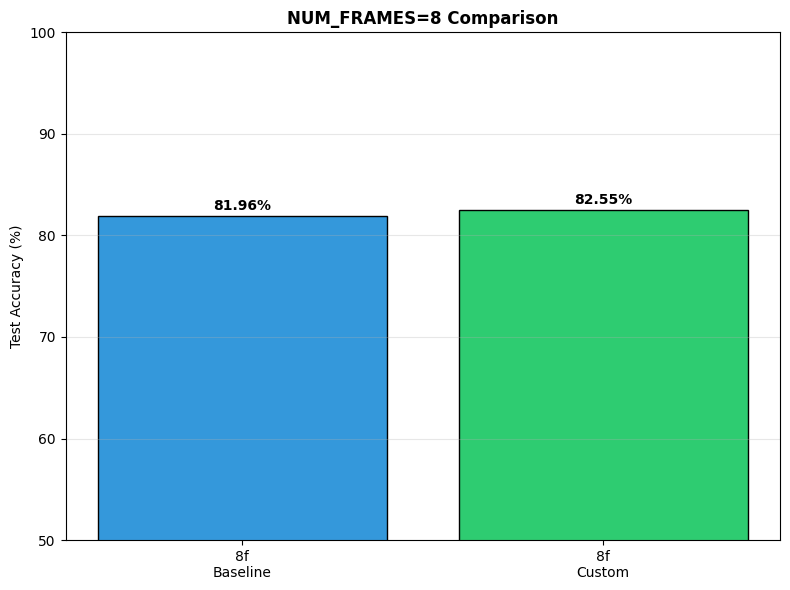

In [21]:
## Compare Results
import pandas as pd
import matplotlib.pyplot as plt

df1 = pd.read_csv('results_8frames.csv')
df2 = pd.read_csv('results_8frames_custom.csv')
df = pd.concat([df1, df2])

print("="*60)
print("8-FRAME RESULTS")
print("="*60)
print(df.to_string(index=False))

# Compare with 16-frame (from main ablation)
print("\n--- Comparison with 16-frame baseline ---")
baseline_8 = df[df['exp'] == '8frames_baseline']['test_acc'].values[0]
custom_8 = df[df['exp'] == '8frames_custom_full']['test_acc'].values[0]
print(f"8-frame Baseline:      {baseline_8:.4f}")
print(f"8-frame Custom:        {custom_8:.4f}")
print(f"\nImprovement (8f custom vs baseline): {(custom_8 - baseline_8)*100:+.2f}%")

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(['8f\nBaseline', '8f\nCustom'], [baseline_8*100, custom_8*100], color=['#3498db', '#2ecc71'], edgecolor='black')
ax.set_ylabel('Test Accuracy (%)')
ax.set_title('NUM_FRAMES=8 Comparison', fontweight='bold')
for bar, acc in zip(bars, [baseline_8, custom_8]):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'{acc*100:.2f}%', ha='center', fontweight='bold')
ax.set_ylim([50, 100])
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()